# Segmenting and Clustering Neighborhoods in Toronto
## IBM Data Science Capstone
#### Sam Stump, December 23, 2019
***

## Part I
### Gather up postal codes for Toronto

- import packages

In [103]:
import requests
from lxml import html
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

- request the data from the URL into an HTML tree

In [104]:
from sklearn.cluster import KMeans
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
tree = html.fromstring(page.content)

- parse the HTML tree and create the raw dataframe

In [105]:
i = 0
data = []
row = []
for x in tree.xpath('//table[@class="wikitable sortable"]//tr/td//text()'):
    value = x.strip()
    if len(value) > 0:
        row.append(value)
        i += 1
    if i % 3 == 0 and len(row) > 0:
        data.append(row)
        row = []
columns = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(data, columns=columns)


- remove rows with 'Not assigned' boroughs
- update neighborhoods 'Not assigned' with borough name

In [106]:
df = df[df.Borough != 'Not assigned']
df['Neighborhood'] = df['Borough'].where(df['Neighborhood'] == 'Not assigned', df['Neighborhood'])

- group by (postal code, borough) and accumulate a list of neighborhoods

In [107]:
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).reset_index(name='Neighborhood')
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"[Rouge, Malvern]"
1,M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]"
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]"
3,M1G,Scarborough,[Woburn]
4,M1H,Scarborough,[Cedarbrae]
5,M1J,Scarborough,[Scarborough Village]
6,M1K,Scarborough,"[East Birchmount Park, Ionview, Kennedy Park]"
7,M1L,Scarborough,"[Clairlea, Golden Mile, Oakridge]"
8,M1M,Scarborough,"[Cliffcrest, Cliffside, Scarborough Village West]"
9,M1N,Scarborough,"[Birch Cliff, Cliffside West]"


- dataframe shape

In [108]:
df.shape


(103, 3)

## Part II
### Find lat/lng for postal codes
- import geocoder package

In [109]:
import geocoder

- create 2 new (empty) columns "Latitude" and "Longitude"
- for each PostalCode in the data frame
    - call the ArcGIS geocoder
    - retrieve the lat, lng from the response and insert into the columns
(this cell takes a few minutes to run, be patient)

In [110]:
lat = []
lng = []
print("Geocoding...please wait")
for e in df['PostalCode']:
    place = '{}, Toronto, Canada'.format(e)
    g = geocoder.arcgis(place)
    z = g.json
    lat.append(z['lat'])
    lng.append(z['lng'])
print("Done.")

Geocoding...please wait
Done.


- append the new columns to the data frame

In [111]:
df['Latitude'] = lat
df['Longitude'] = lng
df.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"[Rouge, Malvern]",43.811525,-79.195517
1,M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]",43.785665,-79.158725
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]",43.765815,-79.175193
3,M1G,Scarborough,[Woburn],43.768369,-79.217590
4,M1H,Scarborough,[Cedarbrae],43.769688,-79.239440
5,M1J,Scarborough,[Scarborough Village],43.743125,-79.231750
6,M1K,Scarborough,"[East Birchmount Park, Ionview, Kennedy Park]",43.726276,-79.263625
7,M1L,Scarborough,"[Clairlea, Golden Mile, Oakridge]",43.713054,-79.285055
8,M1M,Scarborough,"[Cliffcrest, Cliffside, Scarborough Village West]",43.724235,-79.227925
9,M1N,Scarborough,"[Birch Cliff, Cliffside West]",43.696770,-79.259967


### Create a Map of Toronto with Neighborhoods Superimposed
- use geocoder to find Toronto center

In [112]:
g = geocoder.arcgis('Toronto, ON')
toronto_center = (g.json['lat'], g.json['lng'])
print('Toronto Coordinates:', toronto_center)

Toronto Coordinates: (43.648690000000045, -79.38543999999996)


- plot the map

In [113]:
import folium
toronto_map = folium.Map(location=toronto_center, zoom_start=10)
for lat, lng, borough, neighborhood, postal_code in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood'], df['PostalCode']):
    label = '{} {}, {}'.format(borough, postal_code, neighborhood)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(toronto_map)
toronto_map

## Part III
### Cluster the neighborhoods of Toronto
The location data we will be using for clustering is based on latitude & longitude derived 
from postal codes. Neighborhoods that share postal codes will have identical location 
data, and therefore would naturally cluster together. To simplify the analysis, we will be 
using postal codes as a proxy for neighborhoods, or a set of 'identical' neighborhoods with 
respect to the location data. 

- set up FourSquare credentials

In [114]:
CLIENT_ID = 'VUKHKNADL1KYMIMDT5L5LOWWUSSFZEJZZHGGD0Q1WUL3NZCP' # your Foursquare ID
CLIENT_SECRET = '1KRPTNYDVTS34LJ41IHKHJKOPVIW4FX501NLLH0NCYDXVAHA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: VUKHKNADL1KYMIMDT5L5LOWWUSSFZEJZZHGGD0Q1WUL3NZCP
CLIENT_SECRET:1KRPTNYDVTS34LJ41IHKHJKOPVIW4FX501NLLH0NCYDXVAHA


- define the get_category_type() function to extract the category of a venue

In [115]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

- define the function that will build the dataframe containing all 'nearby' venues

In [116]:
# function takes series of names, latitudes, longitudes & radius, 
# then returns a dataframe of venues nearby to the specified locations     

def get_nearby_venues(names, latitudes, longitudes, radius=500):
    print('Gathering venues, please wait...')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        raw_response = requests.get(url).json()
        if 'groups' in raw_response["response"]:
            results = raw_response['response']['groups'][0]['items']
        else:
            print("{} not found.".format(name))
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Done.')
    return nearby_venues


- build the dataframe for Toronto neighborhoods
- display the dataframe's shape

In [117]:
toronto_venues = get_nearby_venues(df['PostalCode'], df['Latitude'], df['Longitude'])
toronto_venues.rename(columns={'Name': 'Postal Code'}, inplace=True)
print('{} rows, {} columns'.format(toronto_venues.shape[0], toronto_venues.shape[1]))

Gathering venues, please wait...
Done.
2454 rows, 7 columns


- count of unique venue categories

In [118]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 261 uniques categories.


- one hot encode the venue categories for each neighborhood
- add postal code to the dataframe

In [119]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postal Code column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

- build a dataframe that groups the one hot encoding by neighborhood and average the occurrences

In [120]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
print(toronto_grouped.shape)

(99, 262)


- build a dataframe of the most common venues in each postal code

In [121]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Home Service,Eastern European Restaurant,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
1,M1C,Bar,Yoga Studio,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market
2,M1E,Construction & Landscaping,Park,Gym / Fitness Center,Farmers Market,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant
3,M1G,Korean Restaurant,Coffee Shop,Park,Business Service,Indian Restaurant,Yoga Studio,Farm,Ethiopian Restaurant,Event Space,Falafel Restaurant
4,M1H,Playground,Yoga Studio,Farmers Market,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant


- cluster the postal codes

<module 'matplotlib.pyplot' from '/home/sstump/development/ds-capstone/venv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

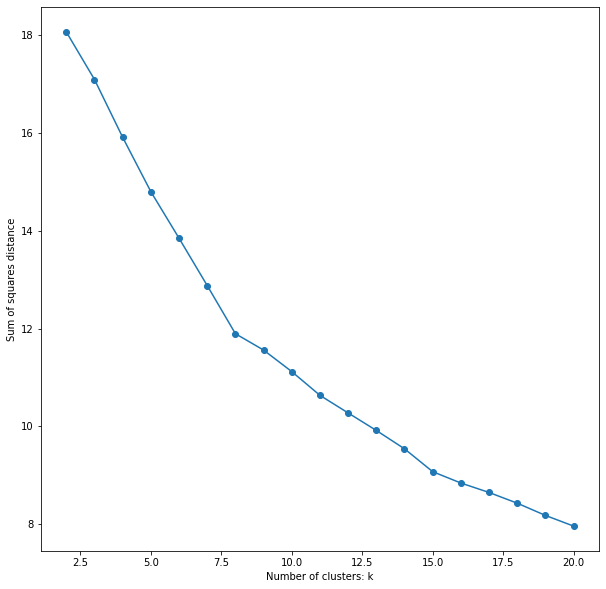

In [122]:
k_list = []
sse = []
tgc = toronto_grouped.drop('Postal Code', 1)
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++',random_state=0).fit(tgc)
#    yhat = kmeans.predict(tgc)
#    print(k, kmeans.score(tgc, yhat))
    k_list.append(k)
    sse.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(k_list, sse, '-o')
plt.xlabel('Number of clusters: k')
plt.ylabel('Sum of squares distance')
plt

- the curve doesn't show a strong elbow, but there is a small one at k=8, so that's where we will proceed.

In [123]:
k = 8
kmeans = KMeans(n_clusters=k, init='k-means++',random_state=0).fit(tgc)

- build a dataframe that includes cluster

In [124]:
# add cluster labels
lbl = list(map(lambda t: int(t), kmeans.labels_))

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', lbl)
toronto_merged = df

toronto_merged = toronto_merged.reset_index(level=0)
#neighborhoods_venues_sorted.head()
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='PostalCode')


- plot the clustered map


In [125]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

# create map
map_clusters = folium.Map(location=toronto_center, zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    if math.isnan(cluster):
        cluster = 0
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- done